In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random 
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn import manifold
from scipy import stats
from itertools import cycle
import umap

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/franciscoperez/anacon

In [2]:
import sys
import utilities as ut
from Network import Net
import Network as nn

In [3]:
train_dataset, test_dataset = ut.load_files(dataset=1)
n = 100000#train_dataset.shape[0] 
epsilon = 0.1
input_size = train_dataset.shape[1]-1
hidden_size = 4
hidden_size2 = 4
num_classes = 2
num_epochs = 2000
batch_size = 250
learning_rate = 0.001
learning_rate2 = 0.001
regularization = False
add_DR_based_data = True
train_dataset = train_dataset.sample(n)
samples = 5000

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0


In [4]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [6]:
train_dataset, test_dataset = ut.delete_outliers(train_dataset, test_dataset)

(78364, 61)
(28625, 60)
(28625, 61)


In [7]:
train_dataset = ut.sort_columns(train_dataset)
test_dataset = ut.sort_columns(test_dataset)

In [8]:
test_dataset_pred = test_dataset.copy()
train_dataset_pred = train_dataset.copy()

In [9]:
data_prior = ut.generate_samples(samples, train_dataset, epsilon,  option = 2)

In [10]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

In [11]:
train_dataset_prior, val_dataset_prior = train_test_split(data_prior, test_size=0.1, random_state=42)

In [12]:
_, _, train_target_prior, train_loader_prior = ut.get_tensors(train_dataset_prior, batch_size)
_, _, val_target_prior, val_loader_prior     = ut.get_tensors(val_dataset_prior, batch_size)
_, _, train_target, train_loader             = ut.get_tensors(train_dataset, batch_size)
_, _, train_target_pred, train_loader_pred   = ut.get_tensors(train_dataset_pred, batch_size)
_, _, val_target, val_loader                 = ut.get_tensors(val_dataset_prior, batch_size)
_, _, test_target, test_loader               = ut.get_tensors(test_dataset, batch_size)
_, _, test_target_pred, test_loader_pred     = ut.get_tensors(test_dataset_pred, batch_size)

____get_tensor_function____
shape tensor:  torch.Size([9000, 60])
____get_tensor_function____
shape tensor:  torch.Size([1001, 60])
____get_tensor_function____
shape tensor:  torch.Size([70527, 60])
____get_tensor_function____
shape tensor:  torch.Size([78364, 60])
____get_tensor_function____
shape tensor:  torch.Size([1001, 60])
____get_tensor_function____
shape tensor:  torch.Size([22840, 60])
____get_tensor_function____
shape tensor:  torch.Size([22840, 60])


/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
net = Net(input_size, hidden_size, hidden_size2, num_classes)
net.cuda()

Net(
  (fc1): Linear(in_features=60, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=4, out_features=2, bias=True)
)

In [14]:
aux_loss_activated = True
num_epochs_prior = 200
EPS1 = 1e-3
EPS2 = 1e-6
hist_val, hist_train = nn.train(net, train_loader, train_loader_prior, val_loader, EPS1, EPS2, learning_rate, input_size)

Epochs:  1000
Epoch:  0
training: epoch:  1  loss:  0.46069522644310873
validating: epoch:  1  loss:  0.06489855647087098
Epoch:  1
training: epoch:  2  loss:  0.24732014763271007
validating: epoch:  2  loss:  0.018634378910064697
Epoch:  2
training: epoch:  3  loss:  0.22533652433868853
validating: epoch:  3  loss:  0.007299438584595919
Epoch:  3
training: epoch:  4  loss:  0.21012038229421676
validating: epoch:  4  loss:  0.0027816630434244873
Epoch:  4
training: epoch:  5  loss:  0.19874124081522332
validating: epoch:  5  loss:  0.0010633025085553527
Epoch:  5
training: epoch:  6  loss:  0.18890189521620215
validating: epoch:  6  loss:  0.0004079232225194573
Epoch:  6
training: epoch:  7  loss:  0.18060583389584672
validating: epoch:  7  loss:  0.00016688890173099935
Epoch:  7
training: epoch:  8  loss:  0.17343088834424744
validating: epoch:  8  loss:  7.526283152401448e-05
Epoch:  8
training: epoch:  9  loss:  0.16682613182931402
validating: epoch:  9  loss:  3.958892775699496e-05

training: epoch:  74  loss:  0.059966094864288826
validating: epoch:  74  loss:  3.999795881099999e-05
Epoch:  74
training: epoch:  75  loss:  0.05976244321507616
validating: epoch:  75  loss:  4.220686096232384e-05
Epoch:  75
training: epoch:  76  loss:  0.059563862495519246
validating: epoch:  76  loss:  4.404830979183316e-05
Epoch:  76
training: epoch:  77  loss:  0.05935966397237441
validating: epoch:  77  loss:  4.62621683254838e-05
Epoch:  77
training: epoch:  78  loss:  0.05915607572549645
validating: epoch:  78  loss:  4.873371217399836e-05
Epoch:  78
training: epoch:  79  loss:  0.058963620054532276
validating: epoch:  79  loss:  5.109538906253874e-05
Epoch:  79
training: epoch:  80  loss:  0.05877831347234047
validating: epoch:  80  loss:  5.333700100891292e-05
Epoch:  80
training: epoch:  81  loss:  0.0586043792207439
validating: epoch:  81  loss:  5.543518345803022e-05
Epoch:  81
training: epoch:  82  loss:  0.05843772372566559
validating: epoch:  82  loss:  5.7489203754812

training: epoch:  145  loss:  0.05295162234297384
validating: epoch:  145  loss:  9.670257568359376e-05
Epoch:  145
training: epoch:  146  loss:  0.052884815273931504
validating: epoch:  146  loss:  9.492855169810355e-05
Epoch:  146
training: epoch:  147  loss:  0.052825094723922626
validating: epoch:  147  loss:  9.358797105960548e-05
Epoch:  147
training: epoch:  148  loss:  0.05277193988946533
validating: epoch:  148  loss:  9.274787735193967e-05
Epoch:  148
training: epoch:  149  loss:  0.05270798314138984
validating: epoch:  149  loss:  9.07532696146518e-05
Epoch:  149
training: epoch:  150  loss:  0.05264267521538499
validating: epoch:  150  loss:  8.931722841225565e-05
Epoch:  150
training: epoch:  151  loss:  0.05258028626165521
validating: epoch:  151  loss:  8.793735760264099e-05
Epoch:  151
training: epoch:  152  loss:  0.05251542261600916
validating: epoch:  152  loss:  8.690853137522936e-05
Epoch:  152
training: epoch:  153  loss:  0.05244499884953874
validating: epoch:  1

training: epoch:  216  loss:  0.04910139078373096
validating: epoch:  216  loss:  2.527103351894766e-05
Epoch:  216
training: epoch:  217  loss:  0.0490546371465279
validating: epoch:  217  loss:  2.492389758117497e-05
Epoch:  217
training: epoch:  218  loss:  0.04900630716524044
validating: epoch:  218  loss:  2.46934883762151e-05
Epoch:  218
training: epoch:  219  loss:  0.048965219362201204
validating: epoch:  219  loss:  2.437000221107155e-05
Epoch:  219
training: epoch:  220  loss:  0.04893044940798211
validating: epoch:  220  loss:  2.40242006839253e-05
Epoch:  220
training: epoch:  221  loss:  0.0489013434647724
validating: epoch:  221  loss:  2.3957253142725675e-05
Epoch:  221
training: epoch:  222  loss:  0.04883924557731977
validating: epoch:  222  loss:  2.3799133487045765e-05
Epoch:  222
training: epoch:  223  loss:  0.04879527162865805
validating: epoch:  223  loss:  2.3278807930182666e-05
Epoch:  223
training: epoch:  224  loss:  0.0487586200638763
validating: epoch:  224

training: epoch:  287  loss:  0.04757124070380896
validating: epoch:  287  loss:  1.3109398423694074e-05
Epoch:  287
training: epoch:  288  loss:  0.047559424240945086
validating: epoch:  288  loss:  1.3099098578095435e-05
Epoch:  288
training: epoch:  289  loss:  0.04754765253092817
validating: epoch:  289  loss:  1.3095283065922558e-05
Epoch:  289
training: epoch:  290  loss:  0.04753630609307504
validating: epoch:  290  loss:  1.3093758025206625e-05
Epoch:  290
training: epoch:  291  loss:  0.047525084514973864
validating: epoch:  291  loss:  1.3090897118672728e-05
Epoch:  291
training: epoch:  292  loss:  0.04751415475676422
validating: epoch:  292  loss:  1.3093948655296118e-05
Epoch:  292
training: epoch:  293  loss:  0.04750345481474071
validating: epoch:  293  loss:  1.3090706488583237e-05
Epoch:  293
training: epoch:  294  loss:  0.04749308003593144
validating: epoch:  294  loss:  1.309642830165103e-05
Epoch:  294
training: epoch:  295  loss:  0.04748326705196089
validating: e

training: epoch:  358  loss:  0.046987554246013453
validating: epoch:  358  loss:  1.2178993347333745e-05
Epoch:  358
training: epoch:  359  loss:  0.04698154289775623
validating: epoch:  359  loss:  1.2162399070803075e-05
Epoch:  359
training: epoch:  360  loss:  0.04697552153202228
validating: epoch:  360  loss:  1.2149429676355793e-05
Epoch:  360
training: epoch:  361  loss:  0.04696953052477154
validating: epoch:  361  loss:  1.214065559906885e-05
Epoch:  361
training: epoch:  362  loss:  0.04696352315520334
validating: epoch:  362  loss:  1.2127494846936315e-05
Epoch:  362
training: epoch:  363  loss:  0.0469574589749581
validating: epoch:  363  loss:  1.211967464769259e-05
Epoch:  363
training: epoch:  364  loss:  0.04695136736841484
validating: epoch:  364  loss:  1.2112617696402594e-05
Epoch:  364
training: epoch:  365  loss:  0.04694561783369144
validating: epoch:  365  loss:  1.2105942005291581e-05
Epoch:  365
training: epoch:  366  loss:  0.04694024254913465
validating: epoc

training: epoch:  428  loss:  0.046639047181332494
validating: epoch:  428  loss:  1.165580761153251e-05
Epoch:  428
training: epoch:  429  loss:  0.04663539451774039
validating: epoch:  429  loss:  1.1660384916467593e-05
Epoch:  429
training: epoch:  430  loss:  0.04663164560870652
validating: epoch:  430  loss:  1.1643981997622177e-05
Epoch:  430
training: epoch:  431  loss:  0.04662776787439526
validating: epoch:  431  loss:  1.163902270491235e-05
Epoch:  431
training: epoch:  432  loss:  0.046624236592081744
validating: epoch:  432  loss:  1.1642074241535738e-05
Epoch:  432
training: epoch:  433  loss:  0.04662067780119791
validating: epoch:  433  loss:  1.1644363257801161e-05
Epoch:  433
training: epoch:  434  loss:  0.046617358748541074
validating: epoch:  434  loss:  1.1647606152109802e-05
Epoch:  434
training: epoch:  435  loss:  0.046613656879524464
validating: epoch:  435  loss:  1.165161156677641e-05
Epoch:  435
training: epoch:  436  loss:  0.04661018821631325
validating: e

training: epoch:  499  loss:  0.043954622010328535
validating: epoch:  499  loss:  2.943420440715272e-06
Epoch:  499
training: epoch:  500  loss:  0.04394188295233692
validating: epoch:  500  loss:  2.9169083063607105e-06
Epoch:  500
training: epoch:  501  loss:  0.04392579987039625
validating: epoch:  501  loss:  2.8850556191173384e-06
Epoch:  501
training: epoch:  502  loss:  0.04391318165397686
validating: epoch:  502  loss:  2.85472870018566e-06
Epoch:  502
training: epoch:  503  loss:  0.04387294854178972
validating: epoch:  503  loss:  2.739715637289919e-06
Epoch:  503
training: epoch:  504  loss:  0.04383356264354694
validating: epoch:  504  loss:  2.69241336354753e-06
Epoch:  504
training: epoch:  505  loss:  0.04378612556366428
validating: epoch:  505  loss:  2.6565552616375498e-06
Epoch:  505
training: epoch:  506  loss:  0.04370359376783716
validating: epoch:  506  loss:  2.6254654585500246e-06
Epoch:  506
training: epoch:  507  loss:  0.043644030983214246
validating: epoch:

training: epoch:  570  loss:  0.043046529342292056
validating: epoch:  570  loss:  1.9264221919002012e-06
Epoch:  570
training: epoch:  571  loss:  0.043040957071492615
validating: epoch:  571  loss:  1.924514799611643e-06
Epoch:  571
training: epoch:  572  loss:  0.043035073959443046
validating: epoch:  572  loss:  1.922607407323085e-06
Epoch:  572
training: epoch:  573  loss:  0.04302941880751625
validating: epoch:  573  loss:  1.9207000150345266e-06
Epoch:  573
training: epoch:  574  loss:  0.04302346412184592
validating: epoch:  574  loss:  1.9191742467228322e-06
Epoch:  574
training: epoch:  575  loss:  0.043017910405098336
validating: epoch:  575  loss:  1.9176482965121978e-06
Epoch:  575
training: epoch:  576  loss:  0.043012264855995824
validating: epoch:  576  loss:  1.915359462145716e-06
Epoch:  576
training: epoch:  577  loss:  0.04300644210549631
validating: epoch:  577  loss:  1.9128799976897424e-06
Epoch:  577
training: epoch:  578  loss:  0.04300108718827314
validating: 

training: epoch:  641  loss:  0.04272062923140534
validating: epoch:  641  loss:  1.7683029000181706e-06
Epoch:  641
training: epoch:  642  loss:  0.04271682480501518
validating: epoch:  642  loss:  1.7652511814958416e-06
Epoch:  642
training: epoch:  643  loss:  0.042712388994573705
validating: epoch:  643  loss:  1.7642974853515626e-06
Epoch:  643
training: epoch:  644  loss:  0.042708102834177315
validating: epoch:  644  loss:  1.7639160432736389e-06
Epoch:  644
training: epoch:  645  loss:  0.04270389414797191
validating: epoch:  645  loss:  1.7639160432736389e-06
Epoch:  645
training: epoch:  646  loss:  0.042699635065038925
validating: epoch:  646  loss:  1.7641066733631306e-06
Epoch:  646
training: epoch:  647  loss:  0.042695408407269646
validating: epoch:  647  loss:  1.7642974853515626e-06
Epoch:  647
training: epoch:  648  loss:  0.04269122528471711
validating: epoch:  648  loss:  1.7642974853515626e-06
Epoch:  648
training: epoch:  649  loss:  0.042687236699983214
validatin

training: epoch:  712  loss:  0.04244036958371898
validating: epoch:  712  loss:  1.728630013531074e-06
Epoch:  712
training: epoch:  713  loss:  0.0424371515515889
validating: epoch:  713  loss:  1.7282485714531503e-06
Epoch:  713
training: epoch:  714  loss:  0.04243396005721585
validating: epoch:  714  loss:  1.7276763173867948e-06
Epoch:  714
training: epoch:  715  loss:  0.04243066994137667
validating: epoch:  715  loss:  1.7271042452193796e-06
Epoch:  715
training: epoch:  716  loss:  0.04242751265583106
validating: epoch:  716  loss:  1.7263411791645921e-06
Epoch:  716
training: epoch:  717  loss:  0.04242437938721883
validating: epoch:  717  loss:  1.725578295008745e-06
Epoch:  717
training: epoch:  718  loss:  0.042421603776093296
validating: epoch:  718  loss:  1.7244339687749743e-06
Epoch:  718
training: epoch:  719  loss:  0.04241851108418547
validating: epoch:  719  loss:  1.7232894606422633e-06
Epoch:  719
training: epoch:  720  loss:  0.04241543489281259
validating: epoc

training: epoch:  783  loss:  0.04223333931340451
validating: epoch:  783  loss:  1.6807556676212697e-06
Epoch:  783
training: epoch:  784  loss:  0.04223062432380953
validating: epoch:  784  loss:  1.6826628780108876e-06
Epoch:  784
training: epoch:  785  loss:  0.04222798970768182
validating: epoch:  785  loss:  1.6859054085216486e-06
Epoch:  785
training: epoch:  786  loss:  0.04222521424135555
validating: epoch:  786  loss:  1.6870499166543595e-06
Epoch:  786
training: epoch:  787  loss:  0.0422226064196745
validating: epoch:  787  loss:  1.6878128008102067e-06
Epoch:  787
training: epoch:  788  loss:  0.04221967051575757
validating: epoch:  788  loss:  1.686477662588004e-06
Epoch:  788
training: epoch:  789  loss:  0.04221702263733313
validating: epoch:  789  loss:  1.686668474576436e-06
Epoch:  789
training: epoch:  790  loss:  0.042212570533682936
validating: epoch:  790  loss:  1.6843796402099542e-06
Epoch:  790
training: epoch:  791  loss:  0.042209912604872835
validating: epo

training: epoch:  854  loss:  0.0420606283326189
validating: epoch:  854  loss:  1.5752792023704388e-06
Epoch:  854
training: epoch:  855  loss:  0.042058598638476
validating: epoch:  855  loss:  1.5733718100818806e-06
Epoch:  855
training: epoch:  856  loss:  0.042056985357414284
validating: epoch:  856  loss:  1.5718460417701863e-06
Epoch:  856
training: epoch:  857  loss:  0.042055091152606076
validating: epoch:  857  loss:  1.570892345625907e-06
Epoch:  857
training: epoch:  858  loss:  0.042049307201729016
validating: epoch:  858  loss:  1.5617370081599802e-06
Epoch:  858
training: epoch:  859  loss:  0.042046944130304215
validating: epoch:  859  loss:  1.5577315934933722e-06
Epoch:  859
training: epoch:  860  loss:  0.042044381900647715
validating: epoch:  860  loss:  1.5550613170489669e-06
Epoch:  860
training: epoch:  861  loss:  0.04204188595943864
validating: epoch:  861  loss:  1.552963294670917e-06
Epoch:  861
training: epoch:  862  loss:  0.042039210111718926
validating: e

training: epoch:  925  loss:  0.04192090813110026
validating: epoch:  925  loss:  1.4726639165019152e-06
Epoch:  925
training: epoch:  926  loss:  0.04191926623243746
validating: epoch:  926  loss:  1.4711379662912805e-06
Epoch:  926
training: epoch:  927  loss:  0.04191741501984874
validating: epoch:  927  loss:  1.4701843610964716e-06
Epoch:  927
training: epoch:  928  loss:  0.04191591202811249
validating: epoch:  928  loss:  1.4692306649521924e-06
Epoch:  928
training: epoch:  929  loss:  0.0419142704963842
validating: epoch:  929  loss:  1.4680862477689515e-06
Epoch:  929
training: epoch:  930  loss:  0.04191265266730908
validating: epoch:  930  loss:  1.4669418305857108e-06
Epoch:  930
training: epoch:  931  loss:  0.04191104257018585
validating: epoch:  931  loss:  1.4656066923635081e-06
Epoch:  931
training: epoch:  932  loss:  0.0419093214054411
validating: epoch:  932  loss:  1.4644622751802672e-06
Epoch:  932
training: epoch:  933  loss:  0.04190772128794935
validating: epoc

training: epoch:  996  loss:  0.04176858439218819
validating: epoch:  996  loss:  1.4451980860030745e-06
Epoch:  996
training: epoch:  997  loss:  0.04176662616964838
validating: epoch:  997  loss:  1.4419555554923135e-06
Epoch:  997
training: epoch:  998  loss:  0.04176468336823077
validating: epoch:  998  loss:  1.4390945580089464e-06
Epoch:  998
training: epoch:  999  loss:  0.041762895791630124
validating: epoch:  999  loss:  1.4364242815645411e-06
Epoch:  999
training: epoch:  1000  loss:  0.041760983363504756
validating: epoch:  1000  loss:  1.4339447261590975e-06


In [15]:
#plt.plot(aux_loss_behaviour)
#plt.show()

In [16]:
nn.get_results(net, train_loader, input_size)
nn.get_results(net, test_loader, input_size)

Accuracy of the network on test objects: 98 %
98
Accuracy of the network on test objects: 71 %
71


array(71)

In [17]:
torch.save(net.state_dict(), 'model.pkl')

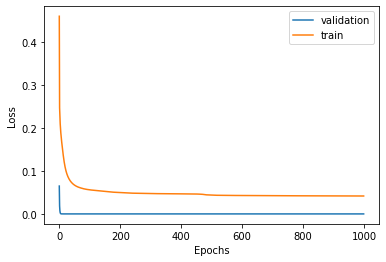

In [18]:
plt.plot(hist_val, label ='validation')
plt.plot(hist_train, label ='train')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('images/'+str(samples)+'_'+str(epsilon)+'_'+str(n)+"_"+str(hidden_size)+"_Loss_Training.png")
plt.show()

In [19]:
#csv_file = open("size_MLP_noise.csv", "a")
#csv_file.write(str(np.asarray(acc_testing))+","+str(np.asarray(acc_training))+","+str(samples)+","+str(epsilon)+","+str(n)+","+str(hidden_size)+"\n")
#csv_file.close()

In [20]:
outputs, intermediates, intermediates2, labels = ut.get_representations(net, train_loader, device)
outputs_test, intermediates_test, intermediates2_test, labels_test = ut.get_representations(net, test_loader, device)

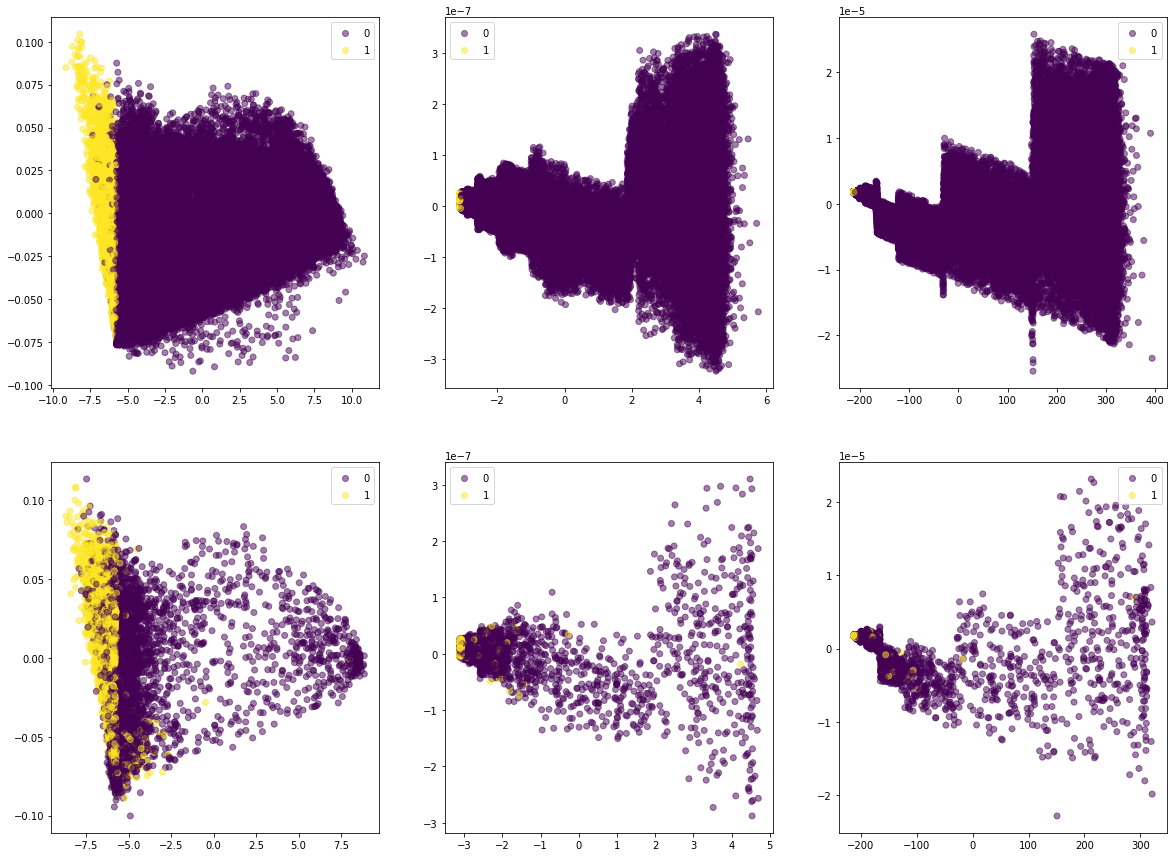

In [21]:
intermediate_pca_data, intermediate_pca_data_test = ut.get_pca(intermediates, data_test=intermediates_test)
fig, axs = plt.subplots(2, 3, figsize=(20,15))
ut.plot_representations(intermediate_pca_data, labels, axs[0, 0])
ut.plot_representations(intermediate_pca_data_test, labels_test, axs[1, 0])
intermediate2_pca_data, intermediate2_pca_data_test = ut.get_pca(intermediates2, data_test=intermediates2_test)
ut.plot_representations(intermediate2_pca_data, labels, axs[0, 1])
ut.plot_representations(intermediate2_pca_data_test, labels_test, axs[1, 1])
output_pca_data, output_pca_data_test = ut.get_pca(outputs, data_test=outputs_test)
ut.plot_representations(output_pca_data, labels, axs[0, 2])
ut.plot_representations(output_pca_data_test, labels_test, axs[1, 2])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20,15))
print('first')
reducer = umap.UMAP()
print('first ..')
mapper_train = reducer.fit_transform(intermediates.numpy())
print('first ...')
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(intermediates_test.numpy())
ut.plot_representations(mapper_train, labels, axs[0, 0])
ut.plot_representations(mapper_test, labels_test, axs[1, 0])

reducer = umap.UMAP()
mapper_train = reducer.fit_transform(intermediates2.numpy())
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(intermediates2_test.numpy())
ut.plot_representations(mapper_train, labels, axs[0, 1])
ut.plot_representations(mapper_test, labels_test, axs[1, 1])

reducer = umap.UMAP()
mapper_train = reducer.fit_transform(outputs.numpy())
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(outputs_test.numpy())

ut.plot_representations(mapper_train, labels, axs[0, 2])
ut.plot_representations(mapper_test, labels_test, axs[1, 2])

first
first ..
first ...


In [ ]:
N_CURVES = 25000

fig, axs = plt.subplots(2, 3, figsize=(20,15))
intermediate_tsne_data, intermediate_tsne_data_test = ut.get_tsne(intermediates, data_test= intermediates_test, n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data, labels, axs[0, 0],  n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data_test, labels_test, axs[1, 0], n_curves = N_CURVES)

intermediate2_tsne_data, intermediate2_tsne_data_test = ut.get_tsne(intermediates2, data_test=intermediates2_test, n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data, labels, axs[0, 1], n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data_test, labels_test, axs[1, 1], n_curves = N_CURVES)

output_tsne_data, output2_tsne_data_test = ut.get_tsne(outputs, data_test=outputs_test, n_curves = N_CURVES)
ut.plot_representations(output_tsne_data, labels, axs[0, 2], n_curves = N_CURVES)
ut.plot_representations(output2_tsne_data_test, labels_test, axs[1, 2], n_curves = N_CURVES)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
curves, labels, probs_train = ut.get_predictions(net, train_loader_pred, device)
pred_labels = probs_train.argmax(1, keepdim = True)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax1)
curves, labels, probs_test = ut.get_predictions(net, test_loader_pred, device)
pred_labels = probs_test.argmax(1, keepdim = True)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax2)

In [ ]:
curves, labels, probs_train_sample = ut.get_predictions(net, train_loader, device)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
ax1.hist(probs_train[:,0], color='black')
ax1.set_xlabel('training set')
ax2.hist(probs_train_sample[:,0], color='black')
ax2.set_xlabel('training set + samples')
ax3.hist(probs_test[:,0], color='black')
ax3.set_xlabel('testing set')
plt.show()

In [ ]:
#N_WEIGHTS = 25
#weights = net.fc2.weight.data
#plot_weights(weights, N_WEIGHTS)

In [ ]:
weights1 = net.fc1.weight.data
w1 = weights1.cpu().numpy().reshape(-1,1)
weights2 = net.fc2.weight.data
w2 = weights2.cpu().numpy().reshape(-1,1)
weights3 = net.fc3.weight.data
w3 = weights3.cpu().numpy().reshape(-1,1)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
ax1.hist(w1, color='black')
ax1.set_xlabel('Layer 1')
ax2.hist(w2, color='black')
ax2.set_xlabel('Layer 2')
ax3.hist(w3, color='black')
ax3.set_xlabel('Layer 3')
plt.show()